In [26]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [4]:
#import training dataset

dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_12_12_a/torch_dataset_all.pkl')

print(dataset)
print(len(dataset))

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
cmd_left_vels_array = dataset[cmd_left_str_list].to_numpy()
cmd_right_vels_array = dataset[cmd_right_str_list].to_numpy()

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
encoder_left_vels_array = dataset[encoder_left_str_list].to_numpy()
encoder_right_vels_array = dataset[encoder_right_str_list].to_numpy()

icp_x_str_list = []
icp_y_str_list = []
icp_z_str_list = []
icp_roll_str_list = []
icp_pitch_str_list = []
icp_yaw_str_list = []
for i in range(0, 40):
    str_icp_x_i = 'icp_x_' + str(i)
    str_icp_y_i = 'icp_y_' + str(i)
    str_icp_z_i = 'icp_z_' + str(i)
    str_icp_roll_i = 'icp_roll_' + str(i)
    str_icp_pitch_i = 'icp_pitch_' + str(i)
    str_icp_yaw_i = 'icp_yaw_' + str(i)
    icp_x_str_list.append(str_icp_x_i)
    icp_y_str_list.append(str_icp_y_i)
    icp_z_str_list.append(str_icp_z_i)
    icp_roll_str_list.append(str_icp_roll_i)
    icp_pitch_str_list.append(str_icp_pitch_i)
    icp_yaw_str_list.append(str_icp_yaw_i)
icp_x_array = dataset[icp_x_str_list].to_numpy()
icp_y_array = dataset[icp_y_str_list].to_numpy()
icp_z_array = dataset[icp_z_str_list].to_numpy()
icp_roll_array = dataset[icp_roll_str_list].to_numpy()
icp_pitch_array = dataset[icp_pitch_str_list].to_numpy()
icp_yaw_array = dataset[icp_yaw_str_list].to_numpy()

# import input space info
input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
ideal_diff_drive = Ideal_diff_drive(input_space_dataframe['calibrated_radius [m]'].to_numpy()[0], input_space_dataframe['calibrated baseline [m]'].to_numpy()[0], 0.05)

# import model error
ideal_diff_drive_errors_dataframe = pd.read_pickle('../data/marmotte/eval_results/grand_salon_b/ideal_diff_drive_full_eval_metrics.pkl')
enhanced_kinematic_errors_dataframe = pd.read_pickle('../data/marmotte/eval_results/grand_salon_b/enhanced_kinematic_full_eval_metrics.pkl')
print(ideal_diff_drive_errors_dataframe)
print(len(ideal_diff_drive_errors_dataframe))

# import powertrain model
time_constant = 1.5
dt = 0.05
bounded_powertrain = Bounded_powertrain(11.5, 11.5, -11.5, -11.5, time_constant, dt)

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0           0.0         0.0         0.0            0.0             0.0   
1           0.0         0.0         0.0            0.0             0.0   
2           0.0         0.0         0.0            0.0             0.0   
3           0.0         0.0         0.0            0.0             0.0   
4           0.0         0.0         0.0            0.0             0.0   
..          ...         ...         ...            ...             ...   
870         0.0         0.0         0.0            0.0             0.0   
871         0.0         0.0         0.0            0.0             0.0   
872         0.0         0.0         0.0            0.0             0.0   
873         0.0         0.0         0.0            0.0             0.0   
874         0.0         0.0         0.0            0.0             0.0   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0             0.0         0.0       

In [5]:
#init model and estimate displacement

body_inertia = 0.8336
body_mass = 70

input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
r = input_space_dataframe['calibrated_radius [m]'].to_numpy()[0]
baseline = input_space_dataframe['calibrated baseline [m]'].to_numpy()[0]
dt = 0.05

trained_params_path = '../eval/training_results/marmotte/enhanced_kinematic/grand_salon_a/train_full_all_horizons.npy'
trained_params = np.load(trained_params_path)

init_stoch_params = np.array([0.01, 0.001, 0.001, 0.01, 0.001, 0.01])


# import input space info
input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
ideal_diff_drive = Ideal_diff_drive(input_space_dataframe['calibrated_radius [m]'].to_numpy()[0], input_space_dataframe['calibrated baseline [m]'].to_numpy()[0], 0.05)
icr_asymmetric_params = np.load('../eval/training_results/marmotte/icr_asymmetrical/grand_salon_a/train_full_all_horizons.npy')
icr_asymmetrical = ICR_asymmetrical(r, icr_asymmetric_params[0], icr_asymmetric_params[1], icr_asymmetric_params[2], icr_asymmetric_params[3], icr_asymmetric_params[4], dt)

enhanced_kinematic = Enhanced_kinematic(r, baseline, body_inertia, body_mass, trained_params, init_stoch_params, dt)


In [53]:
# predict vehicle displacement along window

window_id = 300
# window_id = 303
# window_id = 230
print(cmd_left_vels_array.shape[1])
window_size = cmd_left_vels_array.shape[1]

init_state = np.array([dataset['init_icp_x'][window_id], dataset['init_icp_y'][window_id], dataset['init_icp_x'][window_id]])

predicted_states_idd = np.zeros((window_size, 6))
predicted_states_idd[0, 0] = dataset['init_icp_x'][window_id]
predicted_states_idd[0, 1] = dataset['init_icp_y'][window_id]
predicted_states_idd[0, 2] = dataset['init_icp_z'][window_id]
predicted_states_idd[0, 3] = dataset['init_icp_roll'][window_id]
predicted_states_idd[0, 4] = dataset['init_icp_pitch'][window_id]
predicted_states_idd[0, 5] = dataset['init_icp_yaw'][window_id]

predicted_states_idd_b = np.zeros((window_size, 6))
predicted_states_idd_b[0, 0] = dataset['init_icp_x'][window_id]
predicted_states_idd_b[0, 1] = dataset['init_icp_y'][window_id]
predicted_states_idd_b[0, 2] = dataset['init_icp_z'][window_id]
predicted_states_idd_b[0, 3] = dataset['init_icp_roll'][window_id]
predicted_states_idd_b[0, 4] = dataset['init_icp_pitch'][window_id]
predicted_states_idd_b[0, 5] = dataset['init_icp_yaw'][window_id]

predicted_states_ek = np.zeros((window_size, 6))
predicted_states_ek[0, 0] = dataset['init_icp_x'][window_id]
predicted_states_ek[0, 1] = dataset['init_icp_y'][window_id]
predicted_states_ek[0, 2] = dataset['init_icp_z'][window_id]
predicted_states_ek[0, 3] = dataset['init_icp_roll'][window_id]
predicted_states_ek[0, 4] = dataset['init_icp_pitch'][window_id]
predicted_states_ek[0, 5] = dataset['init_icp_yaw'][window_id]

icp_states = np.zeros((window_size, 6))
icp_states[0, 0] = dataset['init_icp_x'][window_id]
icp_states[0, 1] = dataset['init_icp_y'][window_id]
icp_states[0, 2] = dataset['init_icp_z'][window_id]
icp_states[0, 3] = dataset['init_icp_roll'][window_id]
icp_states[0, 4] = dataset['init_icp_pitch'][window_id]
icp_states[0, 5] = dataset['init_icp_yaw'][window_id]

transitory_left_vel = cmd_left_vels_array[window_id, 0]
transitory_right_vel = cmd_right_vels_array[window_id, 0]

for i in range(1, window_size):
    transitory_left_vel, transitory_right_vel = bounded_powertrain.compute_bounded_wheel_vels(cmd_left_vels_array[window_id, i-1], cmd_right_vels_array[window_id, i-1], 
                                                                                             transitory_left_vel, transitory_right_vel)
    bounded_input_array = np.array([transitory_left_vel, transitory_right_vel])
    print(bounded_input_array)
    unbounded_input_array = np.array([cmd_left_vels_array[window_id, i-1], cmd_right_vels_array[window_id, i-1]])
    predicted_states_ek[i, :] = enhanced_kinematic.predict(predicted_states_ek[i-1, :], unbounded_input_array)
    predicted_states_idd[i, :] = ideal_diff_drive.predict(predicted_states_idd[i-1, :], unbounded_input_array)
    # predicted_states_idd_b[i, :] = ideal_diff_drive.predict(predicted_states_idd_b[i-1, :], bounded_input_array)
    # predicted_states_idd_as[i, :] = icr_asymmetrical.predict(predicted_states_idd_as[i-1, :], unbounded_input_array)
    icp_states[i,:] = np.array([icp_x_array[window_id, i], icp_y_array[window_id, i], icp_z_array[window_id, i], 
                                icp_roll_array[window_id, i], icp_pitch_array[window_id, i], icp_yaw_array[window_id, i]])


40
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.394839   -4.05403001]
[-9.39483

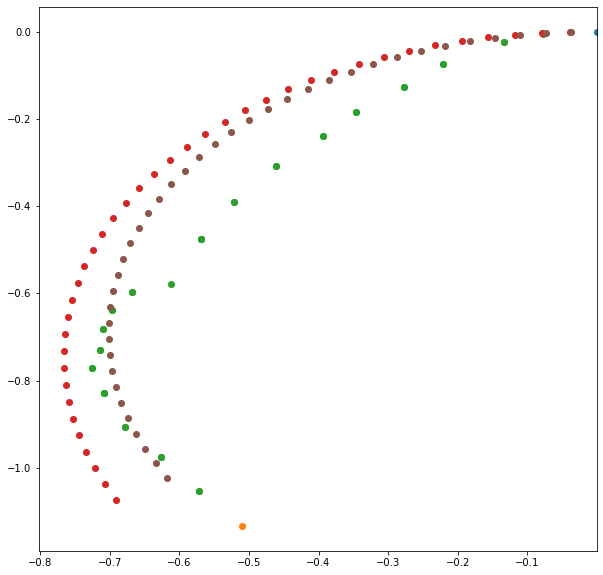

In [54]:
# plot uncertainty propagation

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

alpha_plot = 1.0

int_states = ax.scatter(icp_states[2:40, 0], icp_states[2:40, 1], 
                  c = 'C2', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

prediction_idd = ax.scatter(predicted_states_idd[1:, 0], predicted_states_idd[1:, 1], 
                  c = 'C3', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

# prediction_b = ax.scatter(predicted_states_idd_b[1:, 0], predicted_states_idd_b[1:, 1], 
#                   c = 'C4', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='end_state',
#                  rasterized=True)

init_state = ax.scatter(dataset['init_icp_x'][window_id], dataset['init_icp_y'][window_id], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='init_state',
                 rasterized=True)

end_state = ax.scatter(dataset['gt_icp_x'][window_id], dataset['gt_icp_y'][window_id], 
                  c = 'C1', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)


prediction_ek = ax.scatter(predicted_states_ek[1:, 0], predicted_states_ek[1:, 1], 
                  c = 'C5', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

# prediction_idd_as = ax.scatter(predicted_states_idd_as[1:, 0], predicted_states_idd_as[1:, 1], 
#                   c = 'C4', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='end_state',
#                  rasterized=True)



In [66]:
# propagate prediction uncertainty

new_stoch_params = np.array([1.0, 0.0, 2.69826621e-02, 1.0, 1.71706019e-05, 1.0])
enhanced_kinematic.adjust_stoch_params(new_stoch_params)

prediction_covariances = np.zeros((3,3, window_size))
for i in range(1, window_size):
    transitory_left_vel, transitory_right_vel = bounded_powertrain.compute_bounded_wheel_vels(cmd_left_vels_array[window_id, i-1], cmd_right_vels_array[window_id, i-1], 
                                                                                             transitory_left_vel, transitory_right_vel)
    bounded_input_array = np.array([transitory_left_vel, transitory_right_vel])
    # print(bounded_input_array)
    unbounded_input_array = np.array([cmd_left_vels_array[window_id, i-1], cmd_right_vels_array[window_id, i-1]])
    prediction_covariances[:, :, i] = enhanced_kinematic.propagate_uncertainty(predicted_states_ek[i-1, :], unbounded_input_array, prediction_covariances[:, :, i-1])

predicted_final_state_ek_2d = np.array([predicted_states_ek[-1, 0], predicted_states_ek[-1, 1], predicted_states_ek[-1, 5]])
icp_final_state_2d = np.array([dataset['gt_icp_x'][window_id], dataset['gt_icp_y'][window_id], dataset['gt_icp_yaw'][window_id]])
prediction_residual_ek = icp_final_state_2d - predicted_final_state_ek_2d
print(prediction_residual_ek)
residual_covariance = prediction_residual_ek.reshape(3,1) @ prediction_residual_ek.reshape(3,1).T
print(residual_covariance)

[ 0.10783483 -0.11120166  0.23243379]
[[ 0.01162835 -0.01199141  0.02506446]
 [-0.01199141  0.01236581 -0.02584702]
 [ 0.02506446 -0.02584702  0.05402547]]


In [70]:
def angle_from_rotmat(rotmat):
    angle = np.arctan2(rotmat[1,0], rotmat[0,0])
    return angle

def ellipse_from_covariance_matrix(cov_matrix, center):
    lambdas, R = np.linalg.eig(cov_matrix[:2,:2])
    
    # print(scipy.linalg.eig(cov_matrix[:2,:2]))
    
    scale_x = np.sqrt(lambdas[0])
    scale_y = np.sqrt(lambdas[1])
    
    # print(R)
    
    ellipse_angle = np.degrees(angle_from_rotmat(R))
    # print(ellipse_angle)
    
    return Ellipse(center, scale_x*2, scale_y*2, angle=ellipse_angle, facecolor='none', edgecolor='C1')

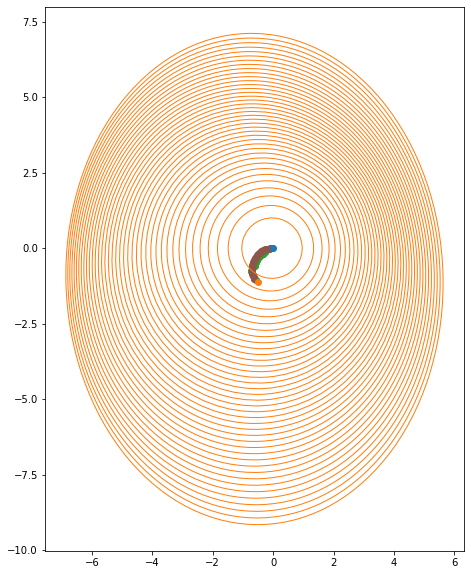

In [71]:
# plot uncertainty propagation

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

alpha_plot = 1.0

int_states = ax.scatter(icp_states[2:40, 0], icp_states[2:40, 1], 
                  c = 'C2', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

prediction_ek = ax.scatter(predicted_states_ek[1:, 0], predicted_states_ek[1:, 1], 
                  c = 'C5', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

init_state = ax.scatter(dataset['init_icp_x'][window_id], dataset['init_icp_y'][window_id], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='init_state',
                 rasterized=True)

end_state = ax.scatter(dataset['gt_icp_x'][window_id], dataset['gt_icp_y'][window_id], 
                  c = 'C1', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

for i in range(0, window_size):
    uncertainty_ellipse = ellipse_from_covariance_matrix(prediction_covariances[:,:,i], predicted_states_ek[i, :2])
    ax.add_patch(uncertainty_ellipse)

# print(residual_covariance)
# residual_ellipse = ellipse_from_covariance_matrix(residual_covariance, predicted_states_ek[-1, :2])
# ax.add_patch(residual_ellipse)
    
ax.set_aspect('equal', 'box')

In [44]:
print(np.linalg.eig(prediction_covariances[:,:,-1]))

(array([ 0.14053487, -0.01724563,  0.02580014]), array([[-0.59152756, -0.75977716, -0.26987738],
       [-0.62887935,  0.2252911 ,  0.74414695],
       [ 0.50458489, -0.60990375,  0.61107406]]))
